# NBA Market Efficiency

This notebook will look at market efficiency over-time using the same methods as the college basketball notebook - [link](https://github.com/squirrelmstr/market_efficiencies/blob/main/College%20Basketball.ipynb)

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss, mean_squared_error

# Data Collection and Cleaning

In [2]:
# Collect and import the odds and results
years = range(2007,2023)

clean_odds = []

for year in years:

    filename = f'nba odds {str(year)}-{str(year+1)[2:]}.xlsx'
    tmp = pd.read_excel('data/' + filename, engine='openpyxl')

    tmp.replace({'Close': {'pk': 0,
                           'PK': 0,
                           'NL': np.nan},
                 '2H': {'pk': 0,
                        'PK': 0,
                        'NL': np.nan,
                        '.5+03': np.nan,
                        '.5ev': np.nan},
                 'ML': {'pk': 100,
                        'PK': 100,
                        '-': 100,
                        'NL': np.nan,
                        'N': np.nan,
                        '+145\xa0': 145,
                        '+155\xa0': 155}}, inplace = True)

    tmp['Close'] = pd.to_numeric(tmp['Close'])
    tmp['2H'] = pd.to_numeric(tmp['2H'])
    tmp['ML'] = pd.to_numeric(tmp['ML'])

    cutoff_month = 8
    # Put in the season
    tmp['season'] = year

    # Format the dates
    tmp['day'] = [str(x)[-2:] for x in tmp['Date']]
    tmp['month'] = [str(x)[:1] if len(str(x)) == 3 else str(x)[:2] for x in tmp['Date']]

    tmp['day'] = tmp['day'].astype(int)
    tmp['month'] = tmp['month'].astype(int)

    tmp['year'] = [year if x > cutoff_month else year+1 for x in tmp['month']]

    tmp['datetime'] = pd.to_datetime(tmp[['year', 'month', 'day']])
    tmp.drop(columns=['day', 'month', 'year'], inplace=True)

    # Split it up into visitor data and home data
    tmp['index_plus_1'] = tmp.index + 1
    tmp['odd_even'] = tmp['index_plus_1'] % 2

    df_v = tmp[tmp['odd_even']==1][['season', 'datetime', 'Date', 'VH', 'Team', '1st', '2nd', 'Final', 'Open', 'Close', 'ML', '2H', 'index_plus_1']]
    df_v.rename(columns = { 'VH': 'v_VH',
                            'Team': 'v_Team',
                            '1st': 'v_1st',
                            '2nd': 'v_2nd',
                            'Final': 'v_Final',
                            'Open': 'v_Open',
                            'Close': 'v_Close',
                            'ML': 'v_ML',
                            '2H': 'v_2H'}, inplace =True)

    df_h = tmp[tmp['odd_even']==0][['VH', 'Team', '1st', '2nd', 'Final', 'Open', 'Close', 'ML', '2H']]
    df_h.rename(columns = { 'VH': 'h_VH',
                            'Team': 'h_Team',
                            '1st': 'h_1st',
                            '2nd': 'h_2nd',
                            'Final': 'h_Final',
                            'Open': 'h_Open',
                            'Close': 'h_Close',
                            'ML': 'h_ML',
                            '2H': 'h_2H'}, inplace =True)

    df = df_v.merge(df_h, how = 'left', left_on = 'index_plus_1', right_index = True)

    df.drop(columns = ['index_plus_1'], inplace=True)

    spread_cutoff = 50

    df['v_spread_close'] = [abs(v) * -1 if abs(v) < spread_cutoff else abs(h) for v,h in zip(df['v_Close'],df['h_Close'])]
    df['h_spread_close'] = [abs(h) * -1 if abs(h) < spread_cutoff else abs(v) for v,h in zip(df['v_Close'],df['h_Close'])]

    df['v_spread_2H'] = [abs(v) * -1 if abs(v) < spread_cutoff else abs(h) for v,h in zip(df['v_2H'],df['h_2H'])]
    df['h_spread_2H'] = [abs(h) * -1 if abs(h) < spread_cutoff else abs(v) for v,h in zip(df['v_2H'],df['h_2H'])]


    df['total'] = [abs(v) if abs(h) < spread_cutoff else abs(h) for v,h in zip(df['v_Close'],df['h_Close'])]

    df['v_implied_probability'] = [(100/(x+100))*100 if x > 0 else (-x/(-x+100))*100 for x in df['v_ML']]
    df['h_implied_probability'] = [(100/(x+100))*100 if x > 0 else (-x/(-x+100))*100 for x in df['h_ML']]

    clean_odds.append(df)

clean_odds = pd.concat(clean_odds)
clean_odds.reset_index(inplace=True, drop=True)

In [3]:
# A few data checks

#clean_odds = clean_odds[(clean_odds['total'] >= 80) & (clean_odds['total'] <= 230)] 

clean_odds['v_Final_calc'] = clean_odds['v_1st'] + clean_odds['v_2nd']
clean_odds['h_Final_calc'] = clean_odds['h_1st'] + clean_odds['h_2nd']
clean_odds = clean_odds[(clean_odds['v_Final_calc'] <= clean_odds['v_Final']) & (clean_odds['h_Final_calc'] <= clean_odds['h_Final'])]

clean_odds['total_finish'] = clean_odds['h_Final'] + clean_odds['v_Final']
clean_odds = clean_odds[clean_odds['total_finish']>70]

#clean_odds = clean_odds[abs(clean_odds['v_spread_close'])<=50]

# Season level market efficiencies

In [4]:
# Create the final game results
clean_odds['v_spread_finish'] = clean_odds['h_Final'] - clean_odds['v_Final']
clean_odds['total_finish'] = clean_odds['h_Final'] + clean_odds['v_Final']
clean_odds['h_win'] = [1 if x>y else 0 for x,y in zip(clean_odds['h_Final'], clean_odds['v_Final'])]

# Get error metrics by year
spread_mse = []
total_mse = []
ml_logloss = []

for season in clean_odds['season'].unique():
    tmp = clean_odds[clean_odds['season']==season]

    tmp_spread = tmp[['v_spread_finish', 'v_spread_close']].dropna()
    season_spread_mse = mean_squared_error(tmp_spread['v_spread_finish'],
                                           tmp_spread['v_spread_close'])
    spread_mse.append(season_spread_mse)

    tmp_close = tmp[['total_finish', 'total']].dropna()
    season_total_mse = mean_squared_error(tmp_close['total'],
                                           tmp_close['total_finish'])
    total_mse.append(season_total_mse)

    tmp_ml = tmp[['h_implied_probability', 'h_win']].dropna()
    season_ml_logloss = log_loss(tmp_ml['h_win'],
                                 tmp_ml['h_implied_probability']/100)
    ml_logloss.append(season_ml_logloss)


season_evaluation_metrics = pd.DataFrame({'season':clean_odds['season'].unique(),
                                          'spread_mse': spread_mse,
                                          'total_mse': total_mse,
                                          'ml_logloss': ml_logloss,})

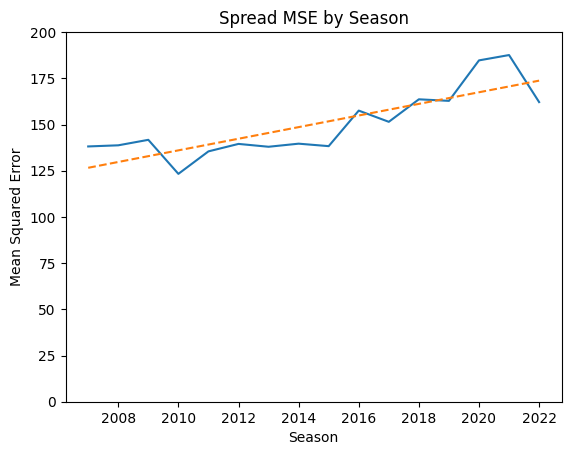

In [5]:
# Spread efficiency by season

plt.plot(season_evaluation_metrics['season'],
         season_evaluation_metrics['spread_mse'])

# linear fit
b, a = np.polyfit(season_evaluation_metrics['season'],
                  season_evaluation_metrics['spread_mse'], deg=1)
xseq = np.arange(season_evaluation_metrics['season'].min(), season_evaluation_metrics['season'].max()+1)
plt.plot(xseq, a + b * xseq, '--')


plt.ylim([0,200])
plt.xlabel('Season')
plt.ylabel('Mean Squared Error')
plt.title('Spread MSE by Season')
plt.show()

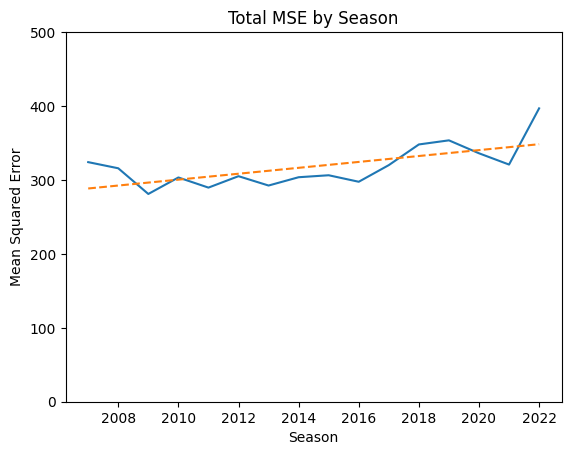

In [6]:
# Total efficiency by season

plt.plot(season_evaluation_metrics['season'],
         season_evaluation_metrics['total_mse'])

# linear fit
b, a = np.polyfit(season_evaluation_metrics['season'],
                  season_evaluation_metrics['total_mse'], deg=1)
xseq = np.arange(season_evaluation_metrics['season'].min(), season_evaluation_metrics['season'].max()+1)
plt.plot(xseq, a + b * xseq, '--')

plt.ylim([0,500])
plt.xlabel('Season')
plt.ylabel('Mean Squared Error')
plt.title('Total MSE by Season')
plt.show()

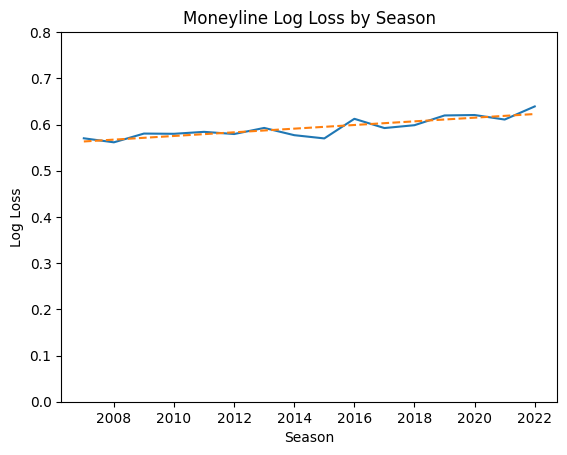

In [7]:
# Moneyline efficiency by season
plt.plot(season_evaluation_metrics['season'],
         season_evaluation_metrics['ml_logloss'])

# linear fit
b, a = np.polyfit(season_evaluation_metrics['season'],
                  season_evaluation_metrics['ml_logloss'], deg=1)
xseq = np.arange(season_evaluation_metrics['season'].min(), season_evaluation_metrics['season'].max()+1)
plt.plot(xseq, a + b * xseq, '--')

plt.ylim([0,.8])
plt.xlabel('Season')
plt.ylabel('Log Loss')
plt.title('Moneyline Log Loss by Season')
plt.show()

## Season level results

In seems that each of the three markets that we've plotted here are all creeping towards becoming less efficient.

Like we did in college basketball, we can try to normalize the spread for the variance in scoring by dividing the season’s root mean square error value by the standard deviation of score differentials.

In [8]:
spread_sd = []
for season in clean_odds['season'].unique():
    spread_values = abs(clean_odds[clean_odds['season']==season]['v_spread_finish'].dropna().values)
    spread_sd.append(np.std(spread_values))
    
season_evaluation_metrics['spread_sd'] = spread_sd
season_evaluation_metrics['MSE/StDev'] = season_evaluation_metrics['spread_mse'] / season_evaluation_metrics['spread_sd']

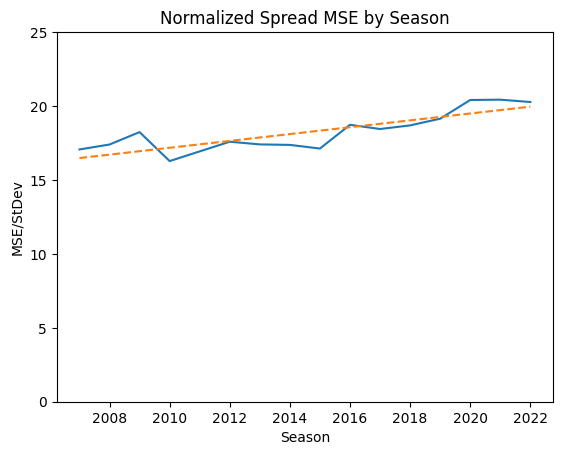

In [9]:
# Normalized spread efficiency by season
plt.plot(season_evaluation_metrics['season'],
         season_evaluation_metrics['MSE/StDev'])

# linear fit
b, a = np.polyfit(season_evaluation_metrics['season'],
                  season_evaluation_metrics['MSE/StDev'], deg=1)
xseq = np.arange(season_evaluation_metrics['season'].min(), season_evaluation_metrics['season'].max()+1)
plt.plot(xseq, a + b * xseq, '--')

plt.ylim([0,25])
plt.xlabel('Season')
plt.ylabel('MSE/StDev')
plt.title('Normalized Spread MSE by Season')
plt.show()

Even with the normalization, this market looks to be less efficient over time.

# Intra-season market efficiencies

Now that we’ve the season level efficiencies over time, we might as well take a look at the way theses markets evolve over a season. In the following plots we’ll look at the same three markets, but this time look at the error metrics on a monthly basis throughout the season.

In [10]:
evals = []

for season in clean_odds['season'].unique():

    tmp = clean_odds[clean_odds['season']==season].copy()
    tmp['month'] = [x.month for x in tmp['datetime']]
    tmp = tmp[tmp['month']!=6]

    for month in tmp['month'].unique():
        tmp_m = tmp[tmp['month']==month].copy()

        tmp_spread = tmp_m[['v_spread_finish', 'v_spread_close']].dropna()
        month_spread_mse = mean_squared_error(tmp_spread['v_spread_finish'],
                                               tmp_spread['v_spread_close'])

        tmp_close = tmp_m[['total_finish', 'total']].dropna()
        month_total_mse = mean_squared_error(tmp_close['total'],
                                              tmp_close['total_finish'])


        tmp_ml = tmp_m[['h_implied_probability', 'h_win']].dropna()
        month_ml_logloss = log_loss(tmp_ml['h_win'],
                                     tmp_ml['h_implied_probability']/100)
        evals.append({'season': season,
                      'month': month,
                      'spread_mse': month_spread_mse,
                      'spread_sd': np.std(abs(tmp_spread['v_spread_finish'])),
                      'total_mse': month_total_mse,
                      'total_sd': np.std(abs(tmp_close['total_finish'])),
                      'ml_logloss': month_ml_logloss,})
evals = pd.DataFrame(evals)

# Add an ordering to the months
month_order = pd.DataFrame({'month': [11, 12, 1, 2, 3, 4, 5],
                            'order': [0,1,2,3,4,5,6]})
evals = evals.merge(month_order, how = 'left', on='month')

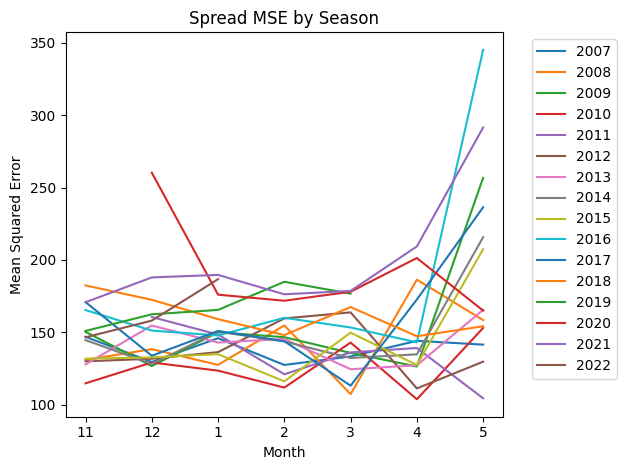

In [11]:
# Spread
for season in evals['season'].unique():
    tmp = evals[(evals['season'] == season)]
    plt.plot(tmp['order'],
         tmp['spread_mse'], label = str(season))
    
plt.xticks(month_order['order'], month_order['month'])
plt.xlabel('Month')
plt.ylabel('Mean Squared Error')
plt.title('Spread MSE by Season')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()

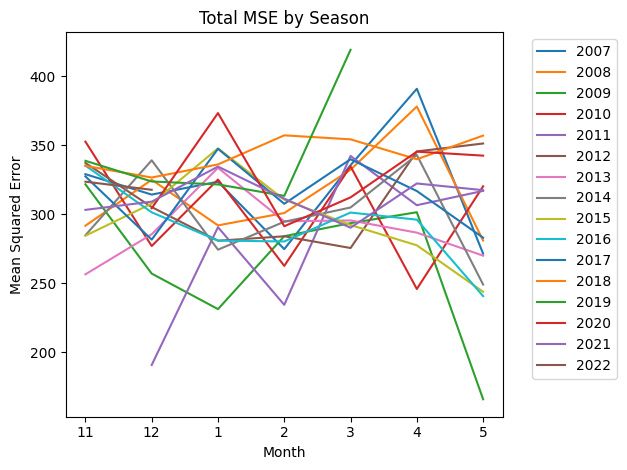

In [12]:
# Total
for season in evals['season'].unique():
    if season == 2022:
        tmp = evals[(evals['season'] == season) & (evals['order'] < 2)]
    else:
        tmp = evals[(evals['season'] == season)]
    plt.plot(tmp['order'],
         tmp['total_mse'], label = str(season))
    #plt.ylim([0,140])
    
plt.xticks(month_order['order'], month_order['month'])
plt.xlabel('Month')
plt.ylabel('Mean Squared Error')
plt.title('Total MSE by Season')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()

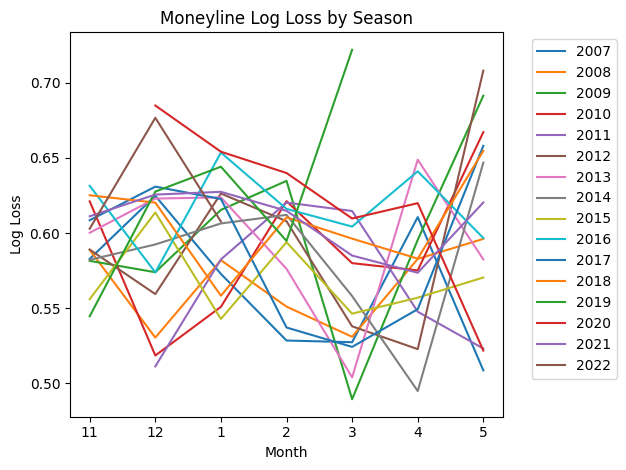

In [13]:
# Moneyline
for season in evals['season'].unique():
    tmp = evals[(evals['season'] == season)]
    plt.plot(tmp['order'],
             tmp['ml_logloss'], label = str(season))
    #plt.ylim([0,140])
    
plt.xticks(month_order['order'], month_order['month'])
plt.xlabel('Month')
plt.ylabel('Log Loss')
plt.title('Moneyline Log Loss by Season')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()

It looks like the error rate across the seasons stay relatively constant.

# Conclusion

In the plots above, we’ve shown that the NBA market efficiencies do change over time. At a season-level, it looks like the each of the markets that we looked at (spread, total, moneyline) are all becoming less efficient over time. Even normalizing for the variance in scoring, the spread market seems to be creeping away from efficiency. 

Looking at the intra-season metrics, it doesn't look like there is a clear positive or negative trend in the error metrics.